# Prediction

# 1. Setting Environment

## 1.1 Load libraries

In [30]:
library(data.table)
library(dplyr)
library(stringr)
library(tidyr)
library(caret)
library(party)
library(randomForest)
library(RColorBrewer)

# 1.2 Load data

In [3]:
activity <- fread("data/futureleague/reform/train_activity_new.csv", stringsAsFactors = F)
guild    <- fread("data/futureleague/reform/train_guild_new.csv", stringsAsFactors = F)
label    <- fread("data/futureleague/reform/train_label.csv", stringsAsFactors = F)
payment  <- fread("data/futureleague/reform/train_payment_new.csv", stringsAsFactors = F)

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:20
Read 800000 rows and 4 (of 4) columns from 0.071 GB file in 00:00:04


## 1.3 Define functions

In [4]:
# Predict churn using Logistic Regressin / Decision Tree / Randomforest without parameter tuning
predict_churn <- function(df, name, binary = T) {
  if (binary == T) {
    df <- df %>% mutate(label = ifelse(label == "retained", "0", "1") %>% factor())
    target <- "2-Class"
  } else {
    df <- df %>% mutate(label = factor(label))
    target <- "4-Class"
  }
  
  # Split
  train_id <- createDataPartition(df$label, p = 0.7, list = F)
  train    <- df[train_id,]
  test     <- df[-train_id,]
  
  # Modeling
  formula <- formula(label ~ .)
  
  dt.fit  <- ctree(formula, data = train)
  rf.fit  <- randomForest(formula, data = train)
  
  # predict
  dt.pred <- predict(dt.fit, test)
  rf.pred <- predict(rf.fit, test)
  
  # Result
  dt.result  <- confusionMatrix(dt.pred, test$label, positive = "1", mode = "everything")
  rf.result  <- confusionMatrix(rf.pred, test$label, positive = "1", mode = "everything")
  
  if (binary == T) {
    glm.fit <- glm(formula, data = train, family = "binomial")
    
    glm.prob <- predict(glm.fit, test, type = "response")
    glm.pred <- factor(ifelse(glm.prob > 0.5, 1, 0))
    
    glm.result <- confusionMatrix(glm.pred, test$label, positive = "1", mode = "everything")
    
    return(list(data = name,
                target = target,
                glm.model = glm.fit,
                dt.model = dt.fit,
                rf.model = rf.fit,
                logistic = glm.result, 
                decision.tree = dt.result, 
                randomforest = rf.result))
  } else {
    return(list(data = name,
                target = target,
                dt.model = dt.fit,
                rf.model = rf.fit,
                decision.tree = dt.result, 
                randomforest = rf.result))
  }
}

In [5]:
# Create result data frame
summarize_result <- function(list) {
  if (length(list) == 8) {
    result <- data.frame(data = rep(list$data, 3),
                         target = rep(list$target, 3),
                         method = c("logistic", "decision tree", "random forest"),
                         accuracy = c(list$logistic$overall["Accuracy"],
                                      list$decision.tree$overall["Accuracy"],
                                      list$randomforest$overall["Accuracy"]),
                         F1 = c(list$logistic$byClass["F1"],
                                list$decision.tree$byClass["F1"],
                                list$randomforest$byClass["F1"]), 
                         stringsAsFactors = F)
  } else if (length(list) == 6) {
    result <- data.frame(data = rep(list$data, 3),
                         target = rep(list$target, 3),
                         method = c("logistic", "decision tree", "random forest"),
                         accuracy = c(NA,
                                      list$decision.tree$overall["Accuracy"],
                                      list$randomforest$overall["Accuracy"]),
                         F1 = c(NA,
                                list$decision.tree$byClass[, "F1"] %>% mean(na.rm = T),
                                list$randomforest$byClass[, "F1"] %>% mean(na.rm = T)), 
                         stringsAsFactors = F)
  } else {
    print("0")
  }
  return(result)
}

## 1.4 ETC Setting

In [40]:
theme_set(theme_bw())
options(repr.plot.width = 10, repr.plot.height = 7)
memory.limit(80000)

[1] 80000

# 2. Preprocessing

In [12]:
head(payment)

payment_id,payment_week,acc_id,payment_amount
M770420,1,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
M208640,2,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
M117311,3,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
M488526,4,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
M77701,5,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985
M383648,6,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd109415062b2bd58709,-0.1498985


## 2.1 Create Payment Variables

In [15]:
pay <- payment %>% 
  mutate(payment_amount_new = (payment_amount - min(payment_amount))/(max(payment_amount) - min(payment_amount))) %>%
  group_by(acc_id) %>%
  summarize(payment_mean = mean(payment_amount_new))
head(pay)

acc_id,payment_mean
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0


## 2.2 Create Guild Variables

In [16]:
guild_join <- guild %>% group_by(acc_id) %>% 
  summarize(join_num = n())
head(guild_join)

acc_id,join_num
000201ba3f72429177413620a3d22dfb348f21622fa7b67e2be2fbf4b06b21f6,1
0007838a3f353aa4a4c938d42ee43a2fa51b03557e624abc6d3ef2375588bd7c,1
00099da993f9a00f3c6575d844d4bf79a658d1e5845a8a17670641e5d15b1be2,1
000af534394783c3a1d28414ce6adc95af45657e34bf7045d41a7ec5cf1ad32f,1
000c7d37960d5261d7680320227e07e53580f654cf0322045a34d50b643a7a1b,1
000f75da470b53684a56be7c49083451cfa58db4573900af1ebe8ad1b1b2be37,1


## 2.3 Create Time Variables

In [17]:
time <- activity %>% 
  mutate(play_time_new = (play_time - min(play_time))/(max(play_time) - min(play_time))) %>%
  group_by(acc_id) %>%
  summarize(wk_num = n(),
            acc_num = sum(cnt_dt),
            acc_mean = mean(cnt_dt),
            time_sum = sum(play_time_new),
            time_wk_mean = mean(play_time_new)) %>%
  mutate(time_acc_mean = time_sum/acc_num) %>%
  select(acc_id, wk_num, acc_num, time_sum)
head(time)

acc_id,wk_num,acc_num,time_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,12,1.434052579
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,25,0.001299603
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,12,0.003850860
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,31,0.158948413
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,3,0.002157738
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,39,0.234343585


## 2.4 Create EXP Variables

In [18]:
exp <- activity %>%
  mutate(npc_exp_new = (npc_exp - min(npc_exp))/(max(npc_exp) - min(npc_exp)),
         npc_hongmun_new = (npc_hongmun - min(npc_hongmun))/(max(npc_hongmun) - min(npc_hongmun)),
         quest_exp_new = (quest_exp - min(quest_exp))/(max(quest_exp) - min(quest_exp)),
         quest_hongmun_new = (quest_hongmun - min(quest_hongmun))/(max(quest_hongmun) - min(quest_hongmun)),
         item_hongmun_new = (item_hongmun - min(item_hongmun))/(max(item_hongmun) - min(item_hongmun))) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            npc_exp_wk_mean = mean(npc_exp_new),
            npc_exp_sum = sum(npc_exp_new),
            npc_hongmun_wk_mean = mean(npc_hongmun_new),
            npc_hongmun_sum = sum(npc_hongmun_new),
            quest_exp_wk_mean = mean(quest_exp_new),
            quest_exp_sum = sum(quest_exp_new),
            quest_hongmun_wk_mean = mean(quest_hongmun_new),
            quest_hongmun_sum = sum(quest_hongmun_new),
            item_hongmun_wk_mean = mean(item_hongmun_new),
            item_hongmun_sum = sum(item_hongmun_new)) %>%
  mutate(npc_exp_acc_mean = npc_exp_sum / acc_num,
         npc_hongmun_acc_mean = npc_hongmun_sum / acc_num,
         quest_exp_acc_mean = quest_exp_sum / acc_num,
         quest_hongmun_acc_mean = quest_hongmun_sum / acc_num,
         item_hongmun_acc_mean = item_hongmun_sum / acc_num) %>%
  select(acc_id, npc_hongmun_sum, quest_hongmun_sum, item_hongmun_sum)
head(exp)

acc_id,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.0007753815,0.225648815,0.0000000000
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.0000000000,0.000000000,0.0000000000
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.0000000000,0.000000000,0.0000000000
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.0002182794,0.041978847,0.0002675048
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.0000000000,0.000000000,0.0000000000
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.0019382450,0.005506965,0.0027419247


## 2.5 Create Dungeon Variables

In [19]:
dungeon_temp <- apply(activity[,c(17:30)], 2, function(x) { (x - min(x))/(max(x) - min(x)) }) %>% 
  as.data.frame() %>% cbind(activity[,c(2,3,4)]) %>% select(acc_id, wk, cnt_dt, everything())

In [21]:
dungeon <- dungeon_temp %>%
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal,
         enter_skilled = cnt_enter_inzone_skilled,
         enter_raid = cnt_enter_raid + cnt_enter_raid_light,
         enter_bam = cnt_enter_bam,
         clear_inzone = cnt_clear_inzone_solo + cnt_clear_inzone_normal,
         clear_skilled = cnt_clear_inzone_skilled,
         clear_raid = cnt_clear_raid + cnt_clear_raid_light,
         clear_bam = cnt_clear_bam) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            enter_inzone_sum = sum(enter_inzone),
            enter_inzone_wk_mean = mean(enter_inzone),
            enter_skilled_sum = sum(enter_skilled),
            enter_skilled_wk_mean = mean(enter_skilled),
            enter_raid_sum = sum(enter_raid),
            enter_raid_wk_mean = mean(enter_raid),
            enter_bam_sum = sum(enter_bam),
            enter_bam_wk_mean = mean(enter_bam),
            clear_inzone_sum = sum(clear_inzone),
            clear_inzone_wk_mean = mean(clear_inzone),
            clear_skilled_sum = sum(clear_skilled),
            clear_skilled_wk_mean = mean(clear_skilled),
            clear_raid_sum = sum(clear_raid),
            clear_raid_wk_mean = mean(clear_raid),
            clear_bam_sum = sum(clear_bam),
            clear_bam_wk_mean = mean(clear_bam)) %>%
  mutate(enter_inzone_acc_mean = enter_inzone_sum / acc_num,
         enter_skilled_acc_mean = enter_skilled_sum / acc_num,
         enter_raid_acc_mean = enter_raid_sum / acc_num,
         enter_bam_acc_mean = enter_bam_sum / acc_num,
         clear_inzone_acc_mean = clear_inzone_sum / acc_num,
         clear_skilled_acc_mean = clear_skilled_sum / acc_num,
         clear_raid_acc_mean = clear_raid_sum / acc_num,
         clear_bam_acc_mean = clear_bam_sum / acc_num) %>%
  select(-acc_num) %>%
  select(acc_id, enter_skilled_wk_mean, clear_skilled_wk_mean, 
         enter_inzone_sum, clear_inzone_sum,
         enter_raid_sum, clear_raid_sum)
head(dungeon)

acc_id,enter_skilled_wk_mean,clear_skilled_wk_mean,enter_inzone_sum,clear_inzone_sum,enter_raid_sum,clear_raid_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0.03225806,0.03898635,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0,0,0.00000000,0.00000000,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0,0,0.00000000,0.00000000,0,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0,0,0.17877183,0.17894392,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0,0,0.00000000,0.00000000,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0,0,0.28982361,0.29173639,0,0


# 3. Data Merge

## 3.1 Base line

In [22]:
game0 <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  select(-acc_id)
head(game0)

label,payment_mean,join_num
week,0.0000000,0
week,0.0000000,0
week,0.0000000,0
week,0.1644737,0
week,0.0000000,0
week,0.0000000,0


## 3.2 with time

In [23]:
game1 <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(time, by = "acc_id") %>%
  select(-acc_id)
head(game1)

label,payment_mean,join_num,wk_num,acc_num,time_sum
week,0.0000000,0,1,3,0.3646825397
week,0.0000000,0,4,23,1.6243766534
week,0.0000000,0,1,3,0.2961789021
week,0.1644737,0,1,1,0.0004100529
week,0.0000000,0,3,7,0.2629927249
week,0.0000000,0,1,4,0.3953323413


## 3.3 with time & exp

In [24]:
game2 <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(time, by = "acc_id") %>%
  left_join(exp, by = "acc_id") %>%
  select(-acc_id)
head(game2)

label,payment_mean,join_num,wk_num,acc_num,time_sum,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum
week,0.0000000,0,1,3,0.3646825397,1.675316e-04,0.05877253,0.000000000
week,0.0000000,0,4,23,1.6243766534,4.021697e-03,0.19401024,0.006420116
week,0.0000000,0,1,3,0.2961789021,9.237076e-05,0.03643843,0.000000000
week,0.1644737,0,1,1,0.0004100529,0.000000e+00,0.00000000,0.000000000
week,0.0000000,0,3,7,0.2629927249,2.452081e-03,0.04869407,0.002608172
week,0.0000000,0,1,4,0.3953323413,5.820249e-03,0.04889788,0.003143182


## 3.4 with time & exp & dungeon

In [25]:
game3 <- label  %>% 
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(time, by = "acc_id") %>%
  left_join(exp, by = "acc_id") %>%
  left_join(dungeon, by = "acc_id") %>%
  select(-acc_id)
head(game3)

label,payment_mean,join_num,wk_num,acc_num,time_sum,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum,enter_skilled_wk_mean,clear_skilled_wk_mean,enter_inzone_sum,clear_inzone_sum,enter_raid_sum,clear_raid_sum
week,0.0000000,0,1,3,0.3646825397,1.675316e-04,0.05877253,0.000000000,0,0,0.009677419,0.011695906,0,0
week,0.0000000,0,4,23,1.6243766534,4.021697e-03,0.19401024,0.006420116,0,0,0.425990283,0.413722295,0,0
week,0.0000000,0,1,3,0.2961789021,9.237076e-05,0.03643843,0.000000000,0,0,0.004838710,0.005847953,0,0
week,0.1644737,0,1,1,0.0004100529,0.000000e+00,0.00000000,0.000000000,0,0,0.000000000,0.000000000,0,0
week,0.0000000,0,3,7,0.2629927249,2.452081e-03,0.04869407,0.002608172,0,0,0.095717162,0.105994069,0,0
week,0.0000000,0,1,4,0.3953323413,5.820249e-03,0.04889788,0.003143182,0,0,0.222714142,0.238455482,0,0


## 3.5 time

In [36]:
game_time <- label %>%
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(time, by = "acc_id") %>%
  select(-acc_id)
head(game_time)

label,payment_mean,join_num,wk_num,acc_num,time_sum
week,0.0000000,0,1,3,0.3646825397
week,0.0000000,0,4,23,1.6243766534
week,0.0000000,0,1,3,0.2961789021
week,0.1644737,0,1,1,0.0004100529
week,0.0000000,0,3,7,0.2629927249
week,0.0000000,0,1,4,0.3953323413


## 3.6 exp

In [37]:
game_exp <- label %>%
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(exp, by = "acc_id") %>%
  select(-acc_id)
head(game_exp)

label,payment_mean,join_num,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum
week,0.0000000,0,1.675316e-04,0.05877253,0.000000000
week,0.0000000,0,4.021697e-03,0.19401024,0.006420116
week,0.0000000,0,9.237076e-05,0.03643843,0.000000000
week,0.1644737,0,0.000000e+00,0.00000000,0.000000000
week,0.0000000,0,2.452081e-03,0.04869407,0.002608172
week,0.0000000,0,5.820249e-03,0.04889788,0.003143182


## 3.7 dungeon

In [38]:
game_dungeon <- label %>%
  left_join(pay, by = "acc_id") %>%
  left_join(guild_join, by = "acc_id") %>% 
  mutate(join_num = ifelse(is.na(join_num), 0, join_num)) %>%
  left_join(dungeon, by = "acc_id") %>%
  select(-acc_id)
head(game_dungeon)

label,payment_mean,join_num,enter_skilled_wk_mean,clear_skilled_wk_mean,enter_inzone_sum,clear_inzone_sum,enter_raid_sum,clear_raid_sum
week,0.0000000,0,0,0,0.009677419,0.011695906,0,0
week,0.0000000,0,0,0,0.425990283,0.413722295,0,0
week,0.0000000,0,0,0,0.004838710,0.005847953,0,0
week,0.1644737,0,0,0,0.000000000,0.000000000,0,0
week,0.0000000,0,0,0,0.095717162,0.105994069,0,0
week,0.0000000,0,0,0,0.222714142,0.238455482,0,0


# 4. Prediction

## 4.1 Prediction by Merged

In [26]:
game0_bin  <- predict_churn(game0, "payment / guild", binary = T) # Binary
game0_mul  <- predict_churn(game0, "payment / guild", binary = F) # Multi

game1_bin  <- predict_churn(game1, "+ time", binary = T) # Binary
game1_mul  <- predict_churn(game1, "+ time", binary = F) # Multi

game2_bin  <- predict_churn(game2, "+ exp", binary = T) # Binary
game2_mul  <- predict_churn(game2, "+ exp", binary = F) # Multi

game3_bin  <- predict_churn(game3, "+ dungeon", binary = T) # Binary
game3_mul  <- predict_churn(game3, "+ dungeon", binary = F) # Multi

## 4.2 Prediction by Seperated

In [41]:
game_time_bin <- predict_churn(game_time, "time", binary = T)
game_time_mul <- predict_churn(game_time, "time", binary = F)

game_exp_bin <- predict_churn(game_exp, "exp", binary = T)
game_exp_mul <- predict_churn(game_exp, "exp", binary = F)

game_dungeon_bin <- predict_churn(game_dungeon, "dungeon", binary = T)
game_dungeon_mul <- predict_churn(game_dungeon, "dungeon", binary = F)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

# 5. Result

## 5.1 Merged Result

In [31]:
result <- summarize_result(game0_bin) %>%
  bind_rows(summarize_result(game0_mul)) %>%
  bind_rows(summarize_result(game1_bin)) %>%
  bind_rows(summarize_result(game1_mul)) %>%
  bind_rows(summarize_result(game2_bin)) %>%
  bind_rows(summarize_result(game2_mul)) %>%
  bind_rows(summarize_result(game3_bin)) %>%
  bind_rows(summarize_result(game3_mul)) %>%
  mutate(method = factor(method, levels = c("logistic", "decision tree", "random forest")))

Warning message:
"Removed 8 rows containing missing values (geom_bar)."Warning message:
"Removed 8 rows containing missing values (geom_text)."

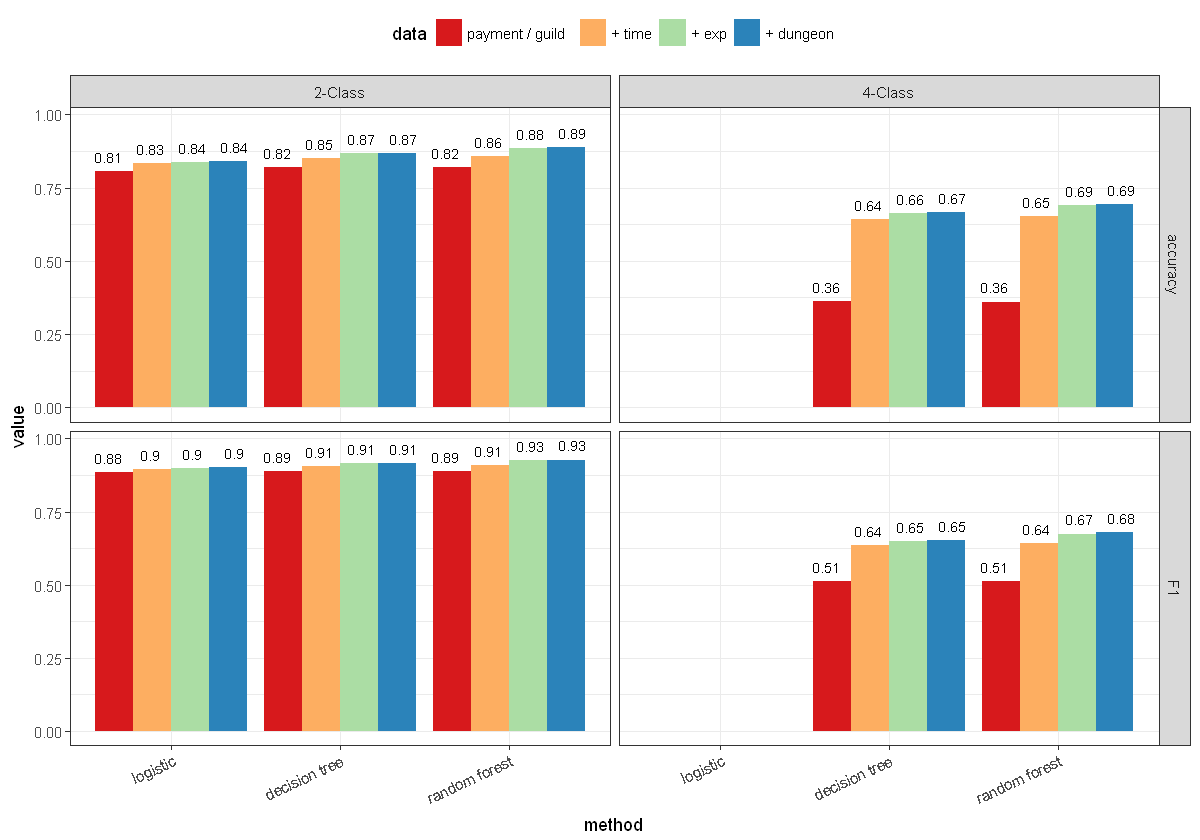

In [34]:
result %>% gather(key = "measure", value = "value", accuracy, F1) %>%
  mutate(data = factor(data, levels = c("payment / guild", "+ time", "+ exp", "+ dungeon"))) %>%
  ggplot(aes(method, value, fill = data)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_text(aes(label = round(value, 2), y = value + 0.05), size = 3, position = position_dodge(width = 1)) + 
  facet_grid(measure ~ target) +
  scale_fill_manual(name = "data", values = brewer.pal(4, "Spectral")) +
  theme(axis.text.x = element_text(angle = 25, hjust = 1),
        legend.position = "top")

## 5.2 Seperated Result

In [42]:
result2 <- summarize_result(game0_bin) %>%
  bind_rows(summarize_result(game0_mul)) %>%
  bind_rows(summarize_result(game_time_bin)) %>%
  bind_rows(summarize_result(game_time_mul)) %>%
  bind_rows(summarize_result(game_exp_bin)) %>%
  bind_rows(summarize_result(game_exp_mul)) %>%
  bind_rows(summarize_result(game_dungeon_bin)) %>%
  bind_rows(summarize_result(game_dungeon_mul)) %>%
  mutate(method = factor(method, levels = c("logistic", "decision tree", "random forest")))

Warning message:
"Removed 8 rows containing missing values (geom_bar)."Warning message:
"Removed 8 rows containing missing values (geom_text)."

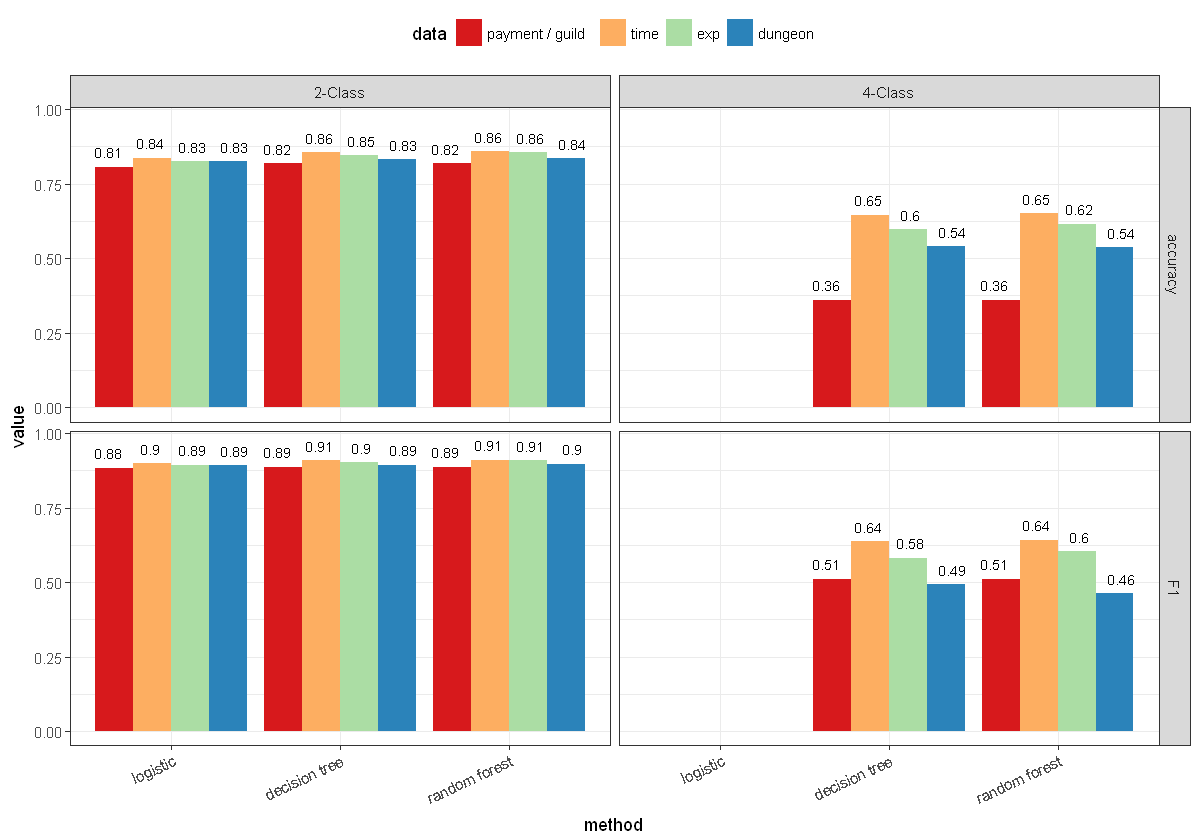

In [45]:
result2 %>% gather(key = "measure", value = "value", accuracy, F1) %>%
  mutate(data = factor(data, levels = c("payment / guild", "time", "exp", "dungeon"))) %>%
  ggplot(aes(method, value, fill = data)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_text(aes(label = round(value, 2), y = value + 0.05), size = 3, position = position_dodge(width = 1)) + 
  facet_grid(measure ~ target) +
  scale_fill_manual(name = "data", values = brewer.pal(4, "Spectral")) +
  theme(axis.text.x = element_text(angle = 25, hjust = 1),
        legend.position = "top")

# 6. Result Analysis

## 6.1 Merged

### 6.1.1 2-Class

#### 6.1.1.1 Base

In [50]:
game0_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  3172  1086
         1  4328 21414
                                          
               Accuracy : 0.8195          
                 95% CI : (0.8151, 0.8239)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4377          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9517          
            Specificity : 0.4229          
         Pos Pred Value : 0.8319          
         Neg Pred Value : 0.7450          
              Precision : 0.8319          
                 Recall : 0.9517          
                     F1 : 0.8878          
             Prevalence : 0.7500          
         Detection Rate : 0.7138          
   Detection Prevalence : 0.8581          
      Balanced Accuracy : 0.6873          
                  

Variable,Overall
payment_mean,3420.580
join_num,3035.783


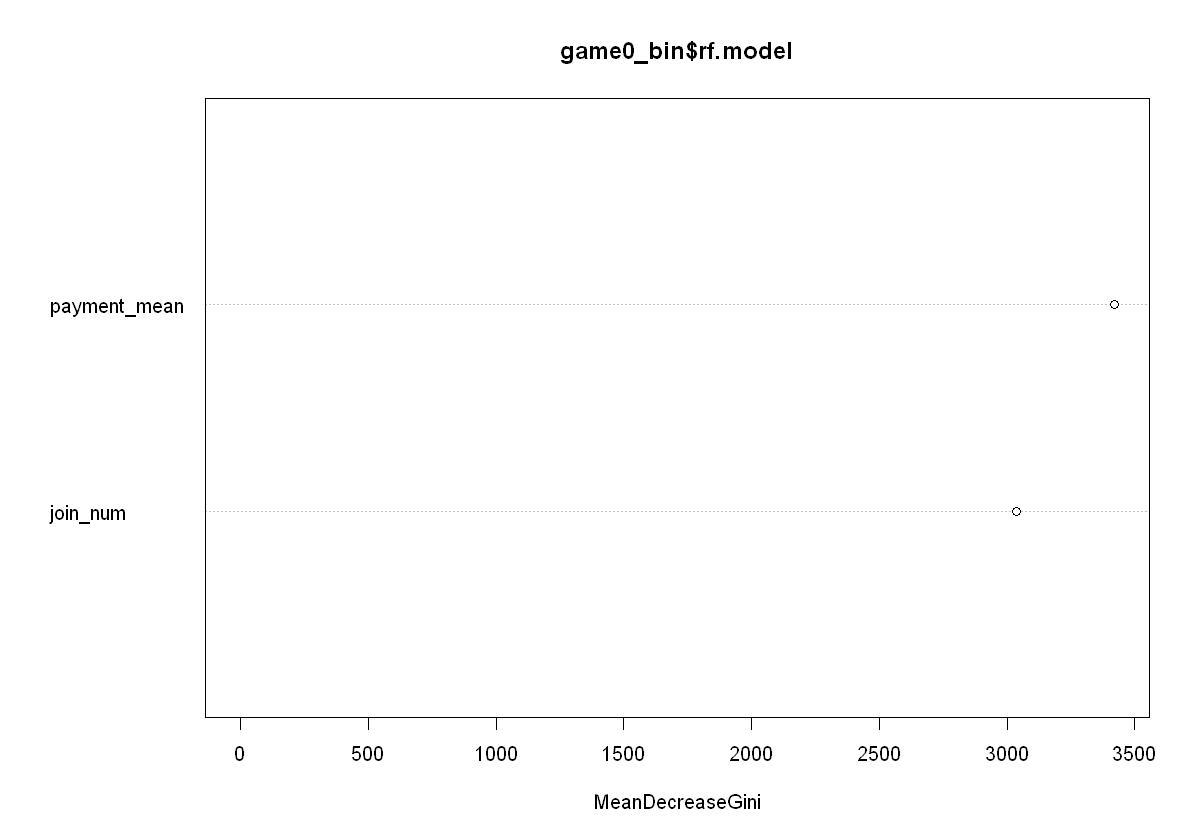

In [56]:
varImp(game0_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game0_bin$rf.model)

#### 6.1.1.2 With Time

In [72]:
game1_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  4340  1111
         1  3160 21389
                                          
               Accuracy : 0.8576          
                 95% CI : (0.8536, 0.8616)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5823          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9506          
            Specificity : 0.5787          
         Pos Pred Value : 0.8713          
         Neg Pred Value : 0.7962          
              Precision : 0.8713          
                 Recall : 0.9506          
                     F1 : 0.9092          
             Prevalence : 0.7500          
         Detection Rate : 0.7130          
   Detection Prevalence : 0.8183          
      Balanced Accuracy : 0.7646          
                  

Variable,Overall
wk_num,4013.720
time_sum,3649.168
join_num,2608.079
acc_num,2481.747
payment_mean,2246.866


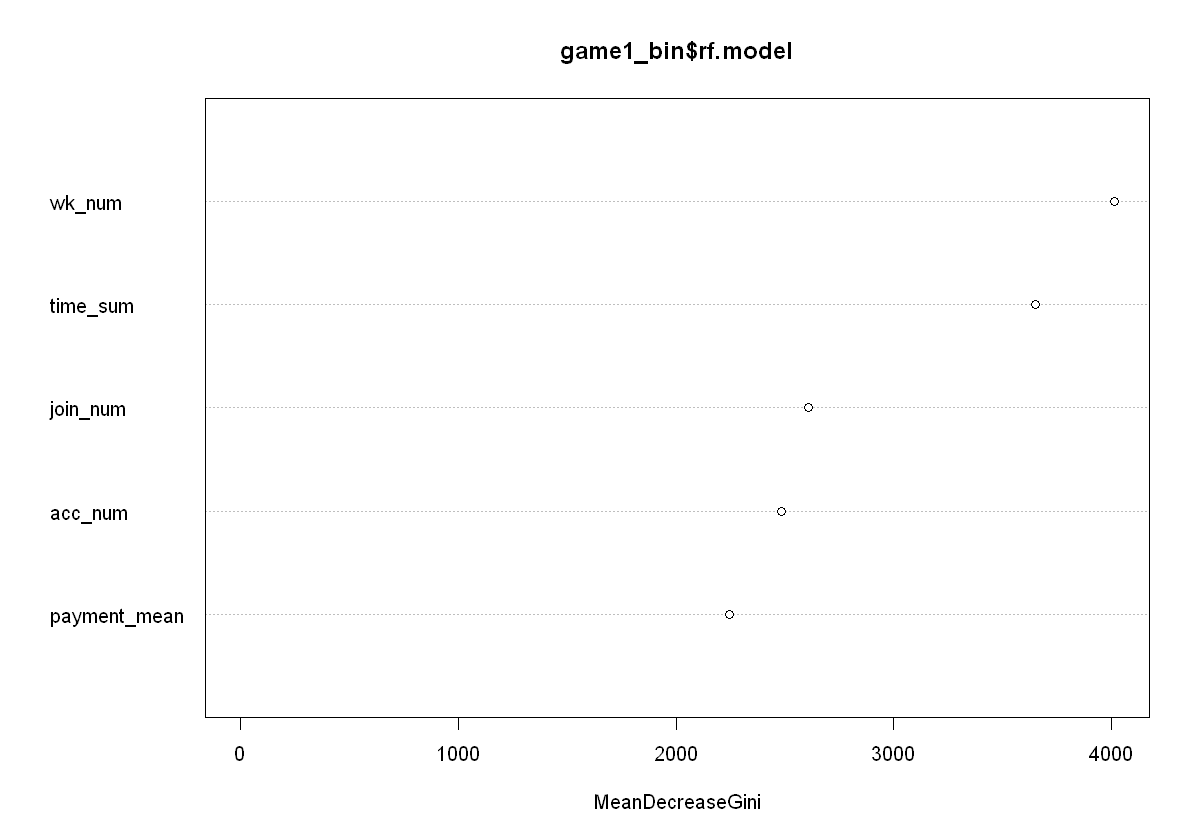

In [73]:
varImp(game1_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game1_bin$rf.model)

#### 6.1.1.3 With EXP

In [74]:
game2_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  5186  1147
         1  2314 21353
                                         
               Accuracy : 0.8846         
                 95% CI : (0.881, 0.8882)
    No Information Rate : 0.75           
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6755         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9490         
            Specificity : 0.6915         
         Pos Pred Value : 0.9022         
         Neg Pred Value : 0.8189         
              Precision : 0.9022         
                 Recall : 0.9490         
                     F1 : 0.9250         
             Prevalence : 0.7500         
         Detection Rate : 0.7118         
   Detection Prevalence : 0.7889         
      Balanced Accuracy : 0.8202         
                                      

Variable,Overall
item_hongmun_sum,3883.111
wk_num,2851.469
time_sum,2675.833
acc_num,2570.642
quest_hongmun_sum,2050.251
npc_hongmun_sum,1937.755
join_num,1609.738
payment_mean,1557.005


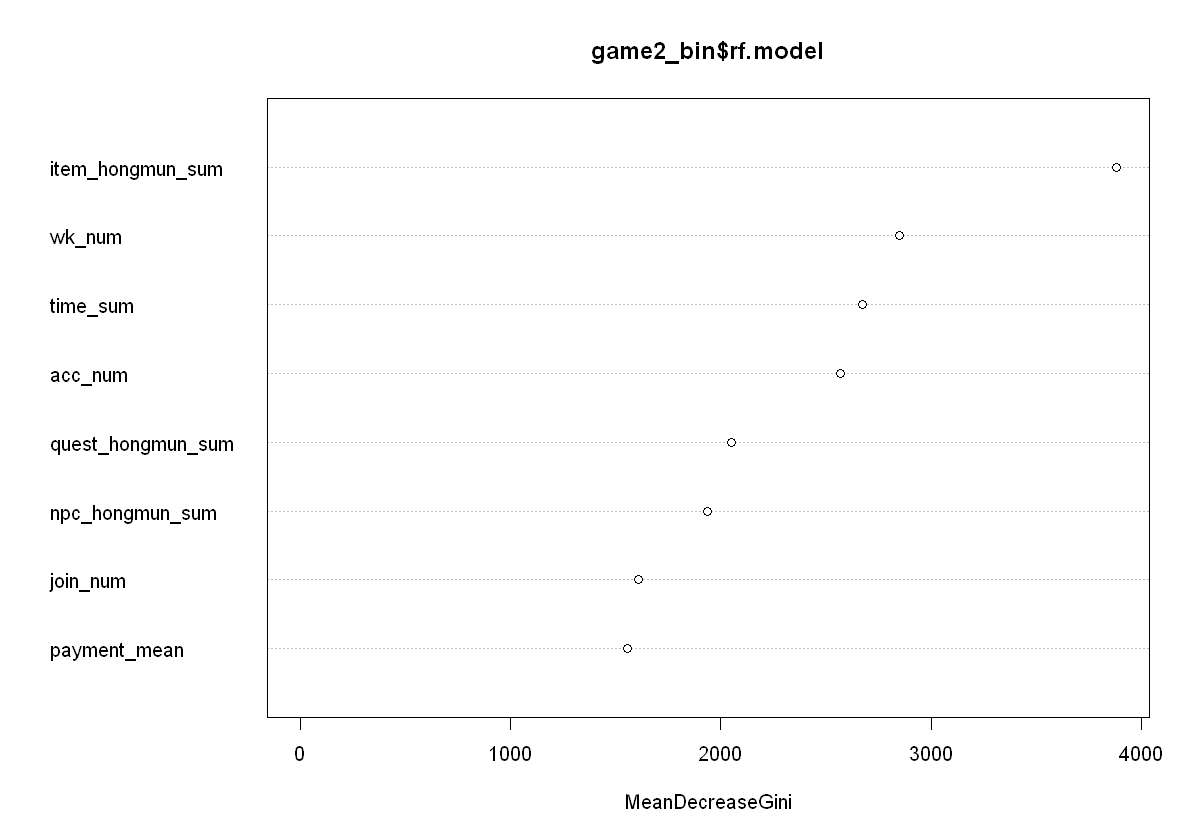

In [75]:
varImp(game2_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game2_bin$rf.model)

#### 6.1.1.4 With Dungeon

In [76]:
game3_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  5264  1117
         1  2236 21383
                                          
               Accuracy : 0.8882          
                 95% CI : (0.8846, 0.8918)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6864          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9504          
            Specificity : 0.7019          
         Pos Pred Value : 0.9053          
         Neg Pred Value : 0.8249          
              Precision : 0.9053          
                 Recall : 0.9504          
                     F1 : 0.9273          
             Prevalence : 0.7500          
         Detection Rate : 0.7128          
   Detection Prevalence : 0.7873          
      Balanced Accuracy : 0.8261          
                  

Variable,Overall
item_hongmun_sum,2606.8523
wk_num,2308.4956
time_sum,1987.9680
acc_num,1942.1966
clear_raid_sum,1939.3576
enter_raid_sum,1530.5693
quest_hongmun_sum,1461.8366
npc_hongmun_sum,1251.9896
join_num,1027.4044
clear_inzone_sum,1000.5432


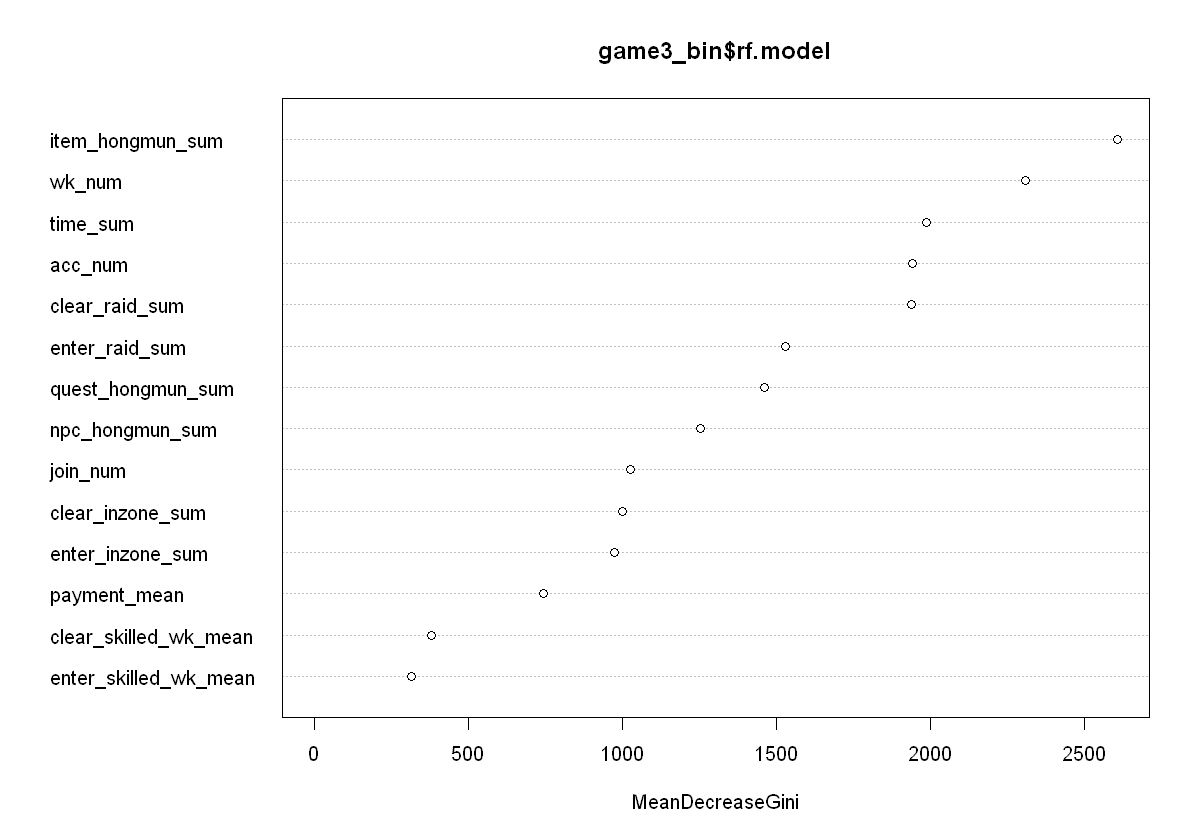

In [77]:
varImp(game3_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game3_bin$rf.model)

### 6.1.2 4-Class

#### 6.1.2.1 Base

In [47]:
game0_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month        0     1        6    0
  month      6865  7018     3682 6861
  retained    634   481     3809  639
  week          1     0        3    0

Overall Statistics
                                          
               Accuracy : 0.3609          
                 95% CI : (0.3555, 0.3664)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1479          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity              0.0000000       0.9357          0.5079   0.0000000
Specificity              0.9996889       0.2263          0.9220   0.9998222
Pos Pred Value           0.0000000       0.2873          0.6847   0.0000000
Neg Pred Value           0.7499417       0.9135          0.8490   

Variable,Overall
join_num,2205.640
payment_mean,2108.593


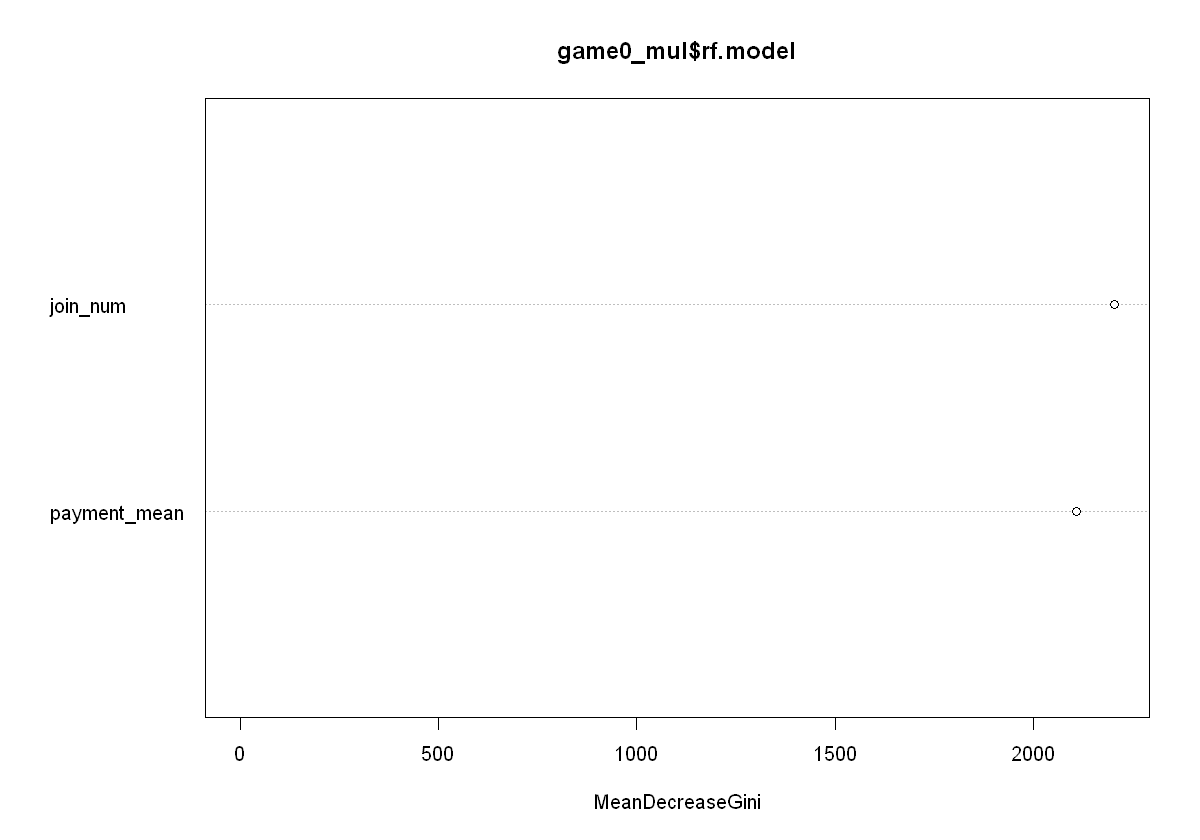

In [64]:
varImp(game0_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game0_mul$rf.model)

#### 6.1.2.2 With Time

In [78]:
game1_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     4831  2631     1221   86
  month      1167  2872      351  600
  retained    994   787     5381  339
  week        508  1210      547 6475

Overall Statistics
                                          
               Accuracy : 0.652           
                 95% CI : (0.6465, 0.6574)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.536           
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.6441      0.38293          0.7175      0.8633
Specificity                 0.8250      0.90587          0.9058      0.8993
Pos Pred Value              0.5509      0.57555          0.7174      0.7408
Neg Pred Value              0.8743      0.81495          0.9058   

Variable,Overall
time_sum,11062.962
acc_num,5215.406
wk_num,3958.040
join_num,2380.788
payment_mean,1729.731


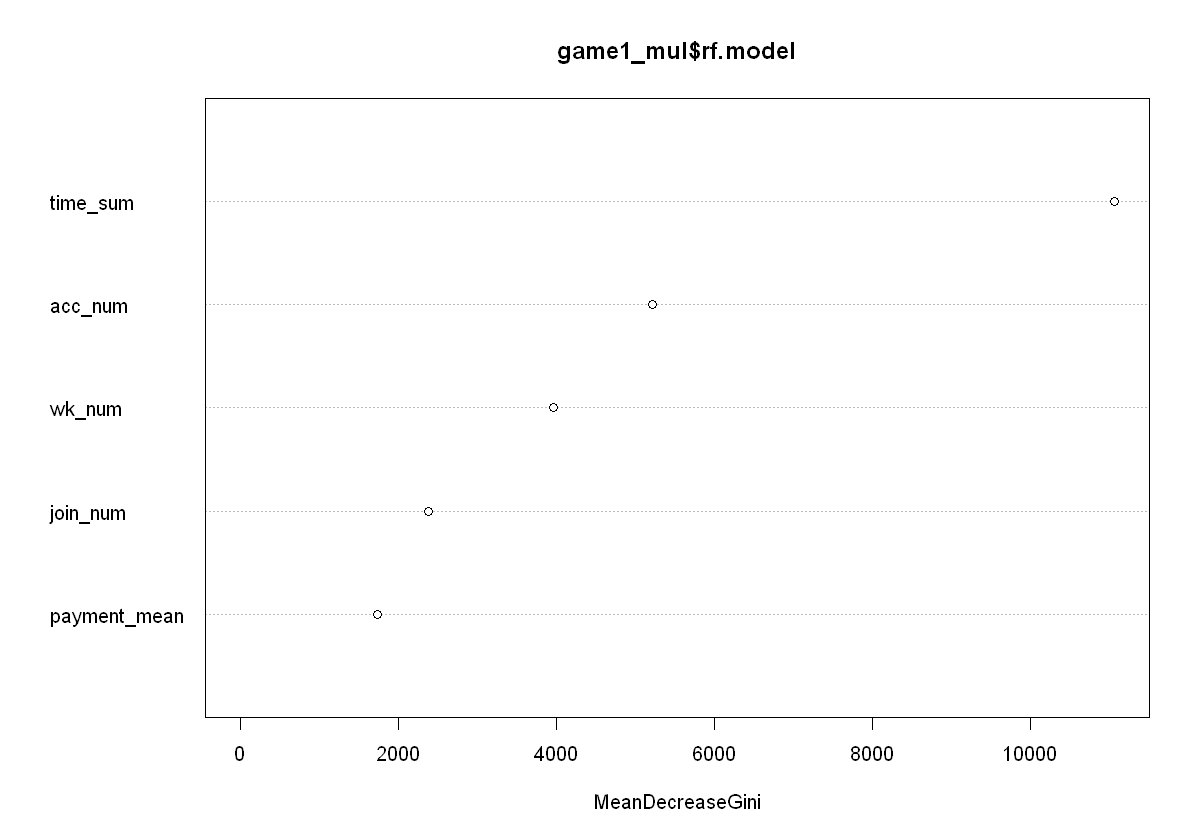

In [79]:
varImp(game1_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game1_mul$rf.model)

#### 6.1.2.3 With EXP

In [80]:
game2_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     5912  3479     1272  127
  month       278  2510      148  453
  retained    913   586     5768  427
  week        397   925      312 6493

Overall Statistics
                                          
               Accuracy : 0.6894          
                 95% CI : (0.6842, 0.6947)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5859          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.7883      0.33467          0.7691      0.8657
Specificity                 0.7832      0.96093          0.9144      0.9274
Pos Pred Value              0.5479      0.74063          0.7497      0.7989
Neg Pred Value              0.9173      0.81248          0.9224   

Variable,Overall
time_sum,6588.266
item_hongmun_sum,5139.660
acc_num,4638.137
npc_hongmun_sum,4607.756
quest_hongmun_sum,4600.204
wk_num,3387.126
join_num,1537.721
payment_mean,1183.290


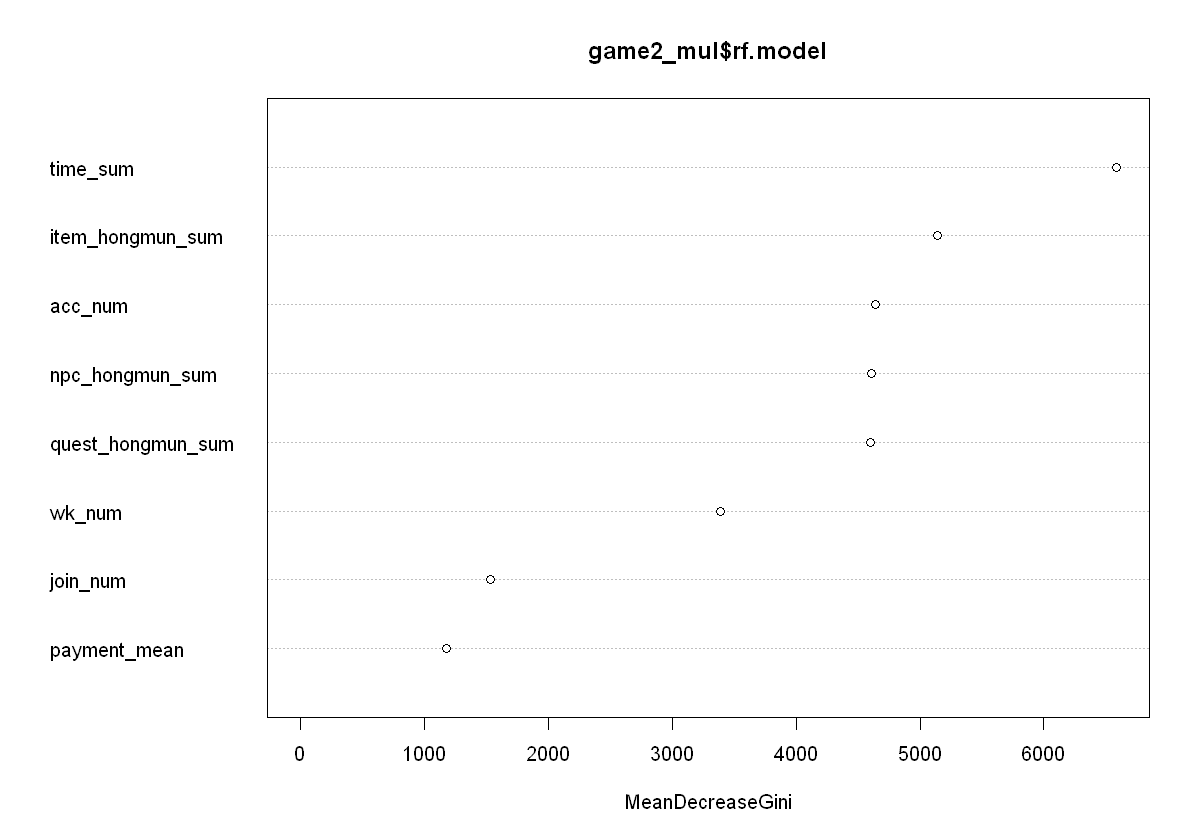

In [81]:
varImp(game2_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game2_mul$rf.model)

#### 6.1.2.4 With Dungeon

In [82]:
game3_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     6167  3576     1503  176
  month       244  2578      116  485
  retained    761   501     5575  366
  week        328   845      306 6473

Overall Statistics
                                          
               Accuracy : 0.6931          
                 95% CI : (0.6878, 0.6983)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5908          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.8223      0.34373          0.7433      0.8631
Specificity                 0.7664      0.96244          0.9276      0.9343
Pos Pred Value              0.5399      0.75314          0.7740      0.8140
Neg Pred Value              0.9282      0.81480          0.9156   

Variable,Overall
time_sum,4982.1852
item_hongmun_sum,3891.4921
acc_num,3860.5484
quest_hongmun_sum,3100.6145
npc_hongmun_sum,3091.1474
enter_inzone_sum,2681.7356
wk_num,2680.7984
clear_inzone_sum,2523.0671
clear_raid_sum,1530.8897
enter_raid_sum,1438.2127


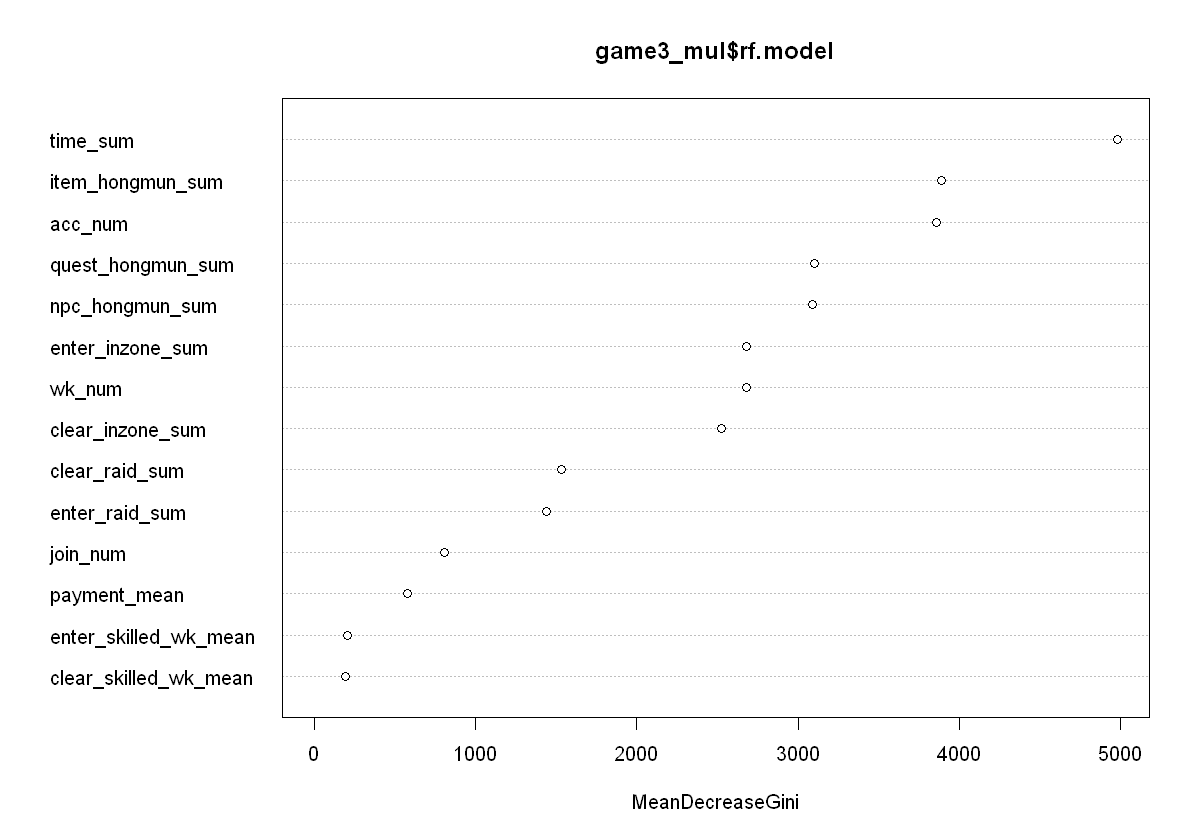

In [83]:
varImp(game3_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game3_mul$rf.model)

## 6.2 Seperated

### 6.2.1 2-Class

#### 6.2.1.1 Time

In [57]:
game_time_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  4273  1020
         1  3227 21480
                                          
               Accuracy : 0.8584          
                 95% CI : (0.8544, 0.8624)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5814          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9547          
            Specificity : 0.5697          
         Pos Pred Value : 0.8694          
         Neg Pred Value : 0.8073          
              Precision : 0.8694          
                 Recall : 0.9547          
                     F1 : 0.9100          
             Prevalence : 0.7500          
         Detection Rate : 0.7160          
   Detection Prevalence : 0.8236          
      Balanced Accuracy : 0.7622          
                  

Variable,Overall
wk_num,3955.587
time_sum,3567.078
join_num,2674.726
acc_num,2435.071
payment_mean,2224.681


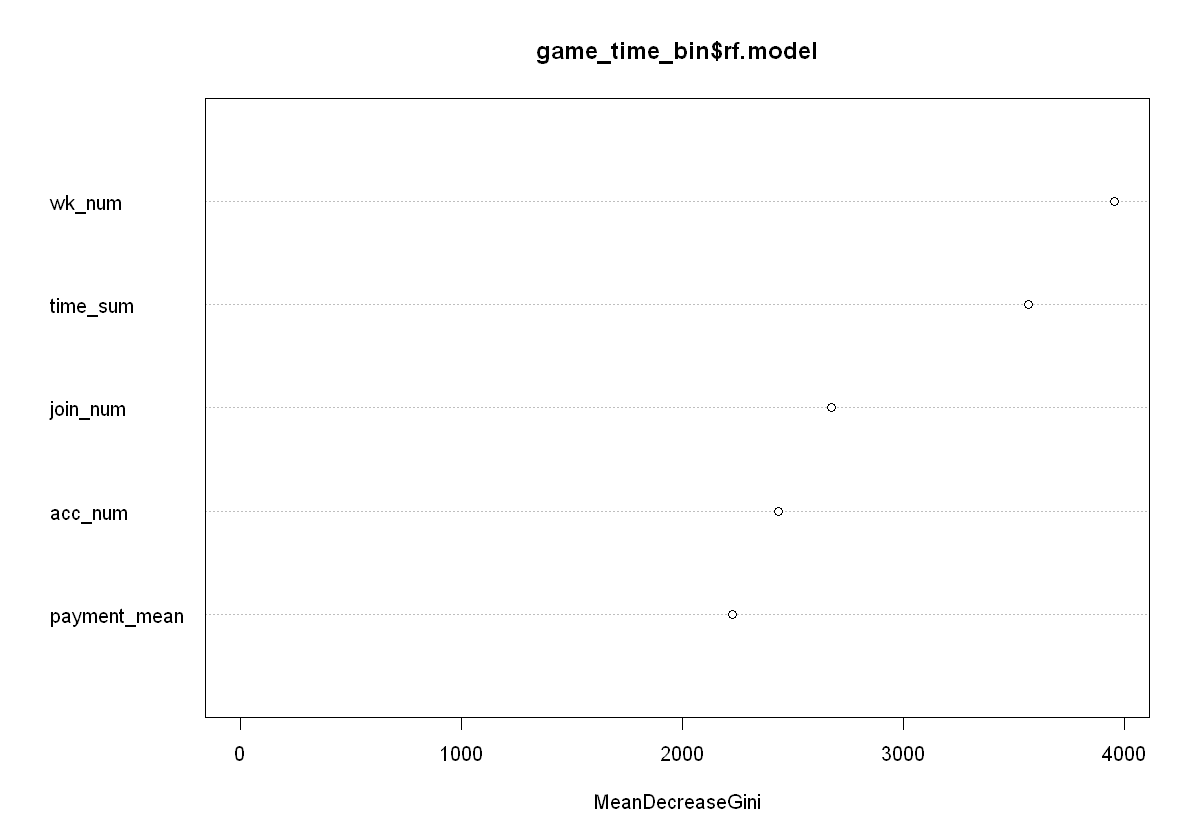

In [58]:
varImp(game_time_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_time_bin$rf.model)

#### 6.2.1.2 EXP

In [59]:
game_exp_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  4203  1052
         1  3297 21448
                                        
               Accuracy : 0.855         
                 95% CI : (0.851, 0.859)
    No Information Rate : 0.75          
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.5706        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9532        
            Specificity : 0.5604        
         Pos Pred Value : 0.8668        
         Neg Pred Value : 0.7998        
              Precision : 0.8668        
                 Recall : 0.9532        
                     F1 : 0.9079        
             Prevalence : 0.7500        
         Detection Rate : 0.7149        
   Detection Prevalence : 0.8248        
      Balanced Accuracy : 0.7568        
                                        
       'Positive'

Variable,Overall
item_hongmun_sum,5834.948
npc_hongmun_sum,2802.541
quest_hongmun_sum,2513.256
join_num,2321.764
payment_mean,1754.117


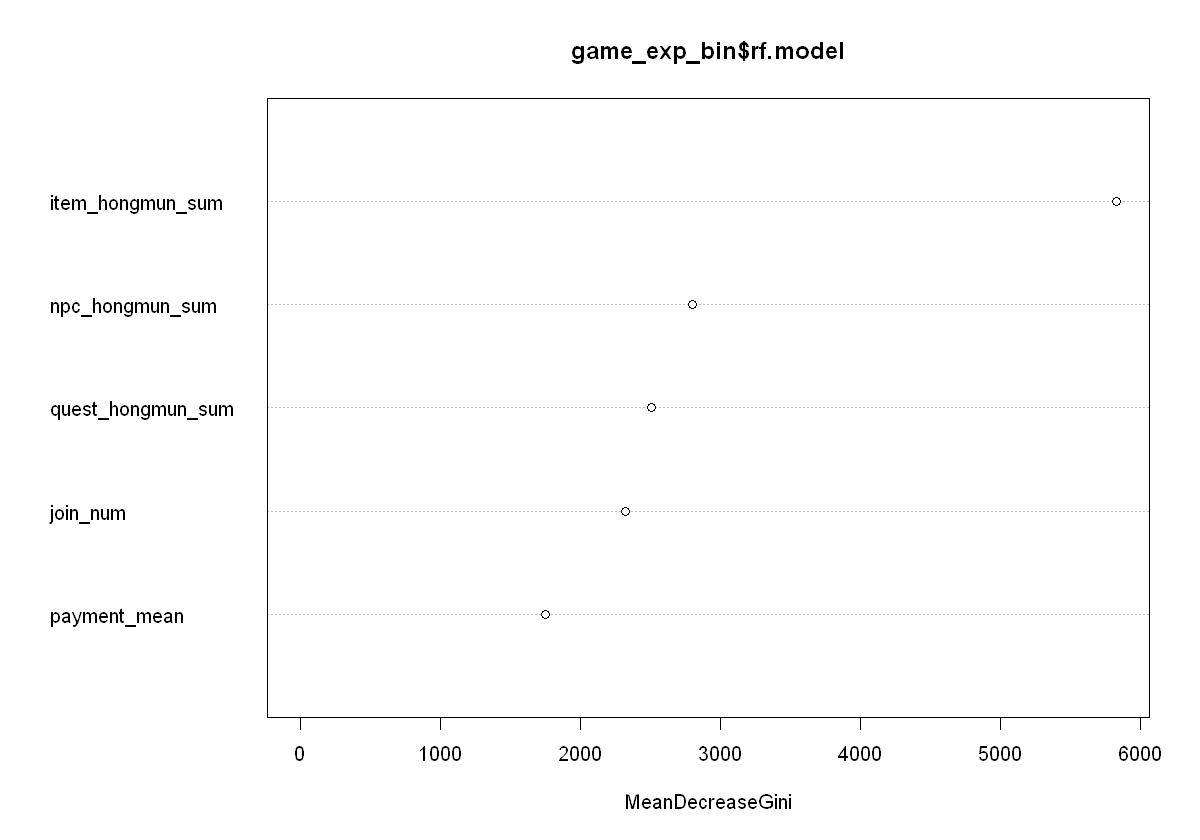

In [61]:
varImp(game_exp_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_exp_bin$rf.model)

#### 6.2.1.3 Dungeon

In [62]:
game_dungeon_bin$randomforest

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  3702  1124
         1  3798 21376
                                          
               Accuracy : 0.8359          
                 95% CI : (0.8317, 0.8401)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5035          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9500          
            Specificity : 0.4936          
         Pos Pred Value : 0.8491          
         Neg Pred Value : 0.7671          
              Precision : 0.8491          
                 Recall : 0.9500          
                     F1 : 0.8968          
             Prevalence : 0.7500          
         Detection Rate : 0.7125          
   Detection Prevalence : 0.8391          
      Balanced Accuracy : 0.7218          
                  

Variable,Overall
clear_raid_sum,2558.3490
enter_raid_sum,2541.8072
join_num,1588.0610
payment_mean,1301.7683
enter_inzone_sum,1215.7128
clear_inzone_sum,1087.2645
clear_skilled_wk_mean,812.4774
enter_skilled_wk_mean,669.1057


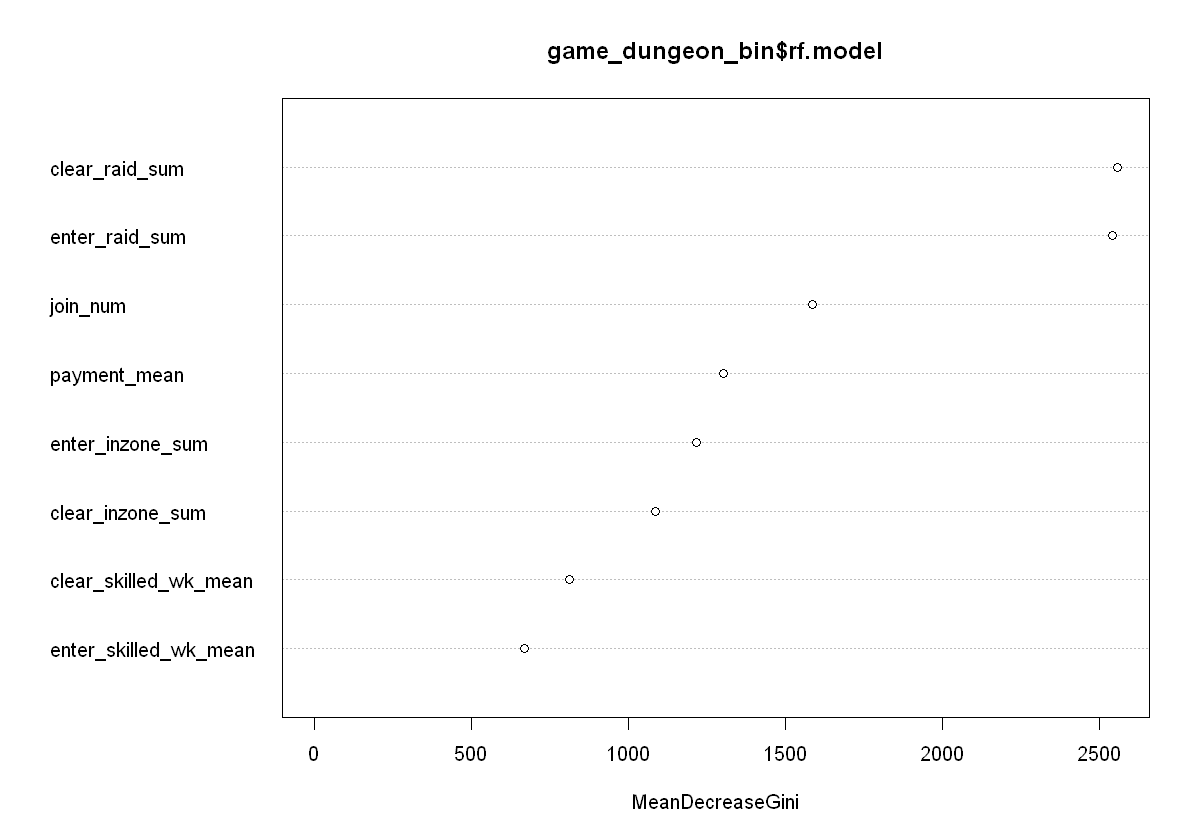

In [63]:
varImp(game_dungeon_bin$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_dungeon_bin$rf.model)

### 6.2.2 4-Class

#### 6.2.2.1 Time

In [65]:
game_time_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     4819  2573     1306   89
  month      1154  2906      354  575
  retained   1005   783     5330  354
  week        522  1238      510 6482

Overall Statistics
                                          
               Accuracy : 0.6512          
                 95% CI : (0.6458, 0.6566)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.535           
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.6425      0.38747          0.7107      0.8643
Specificity                 0.8236      0.90742          0.9048      0.8991
Pos Pred Value              0.5484      0.58248          0.7133      0.7406
Neg Pred Value              0.8736      0.81632          0.9037   

Variable,Overall
time_sum,11236.490
acc_num,5354.753
wk_num,4028.666
join_num,2350.468
payment_mean,1646.773


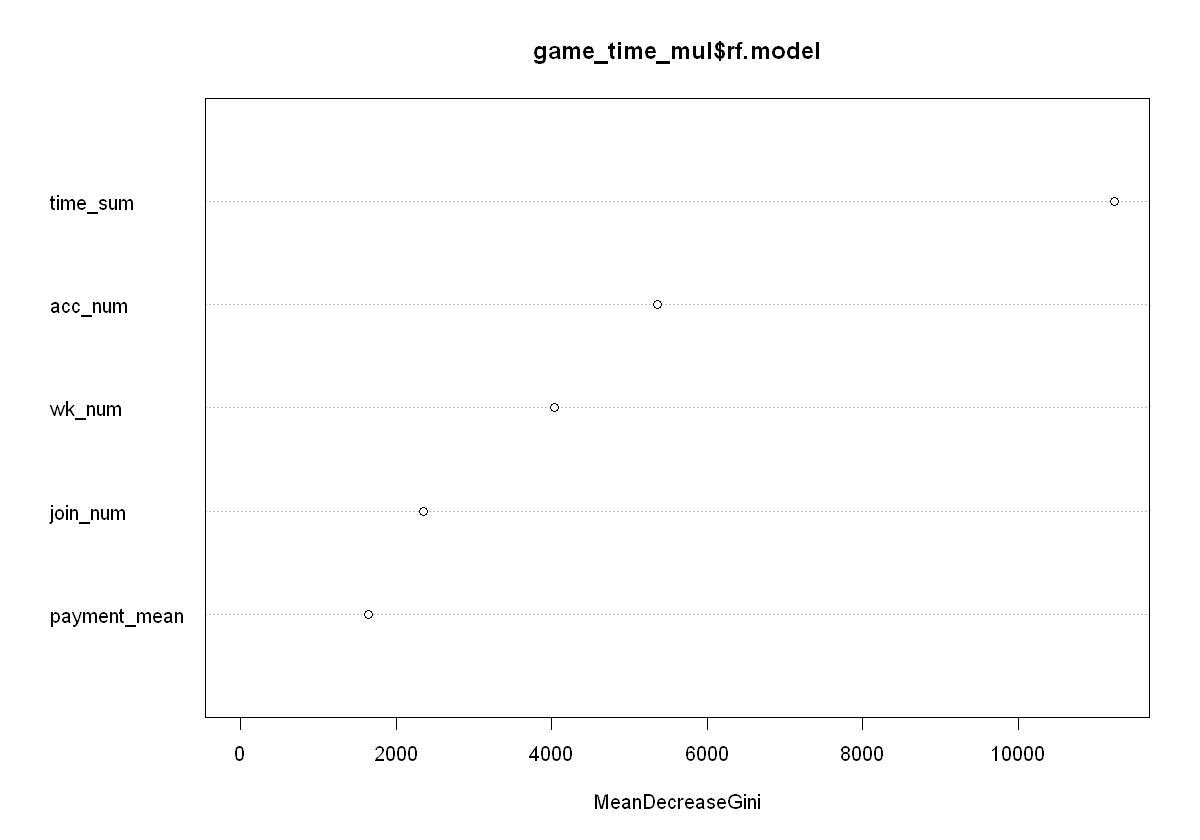

In [67]:
varImp(game_time_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_time_mul$rf.model)

#### 6.2.2.2 EXP

In [49]:
game_exp_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     6368  4072     2343 1182
  month       151  2071      150  492
  retained    741   525     4663  469
  week        240   832      344 5357

Overall Statistics
                                          
               Accuracy : 0.6153          
                 95% CI : (0.6098, 0.6208)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4871          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.8491      0.27613          0.6217      0.7143
Specificity                 0.6624      0.96476          0.9229      0.9371
Pos Pred Value              0.4560      0.72311          0.7288      0.7909
Neg Pred Value              0.9294      0.79993          0.8798   

Variable,Overall
item_hongmun_sum,7387.763
npc_hongmun_sum,6873.367
quest_hongmun_sum,6794.954
join_num,1889.334
payment_mean,1462.762


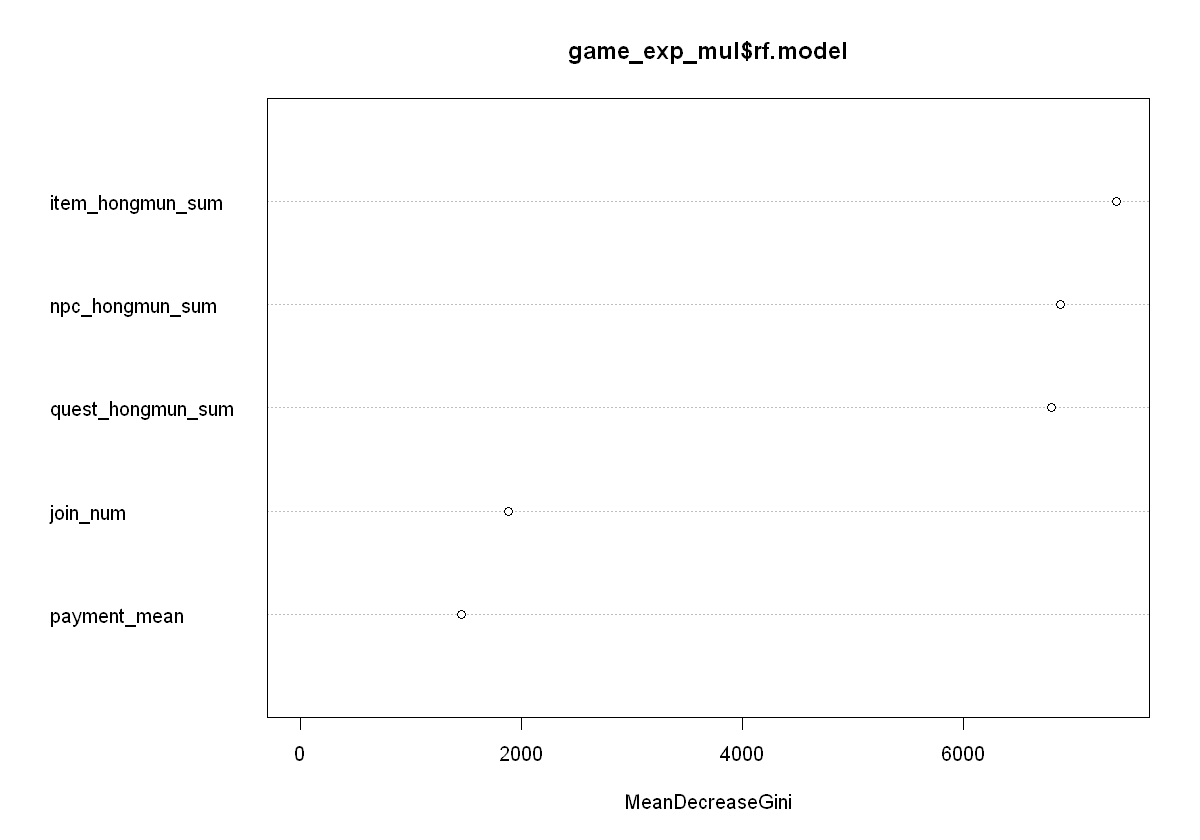

In [68]:
varImp(game_exp_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_exp_mul$rf.model)

#### 6.2.2.3 Dungeon

In [46]:
game_dungeon_mul$randomforest

Confusion Matrix and Statistics

          Reference
Prediction 2month month retained week
  2month     6081  4050     2350 1182
  month         1    11        2    4
  retained    679   611     4204  492
  week        739  2828      944 5822

Overall Statistics
                                          
               Accuracy : 0.5373          
                 95% CI : (0.5316, 0.5429)
    No Information Rate : 0.25            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.383           
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 2month Class: month Class: retained Class: week
Sensitivity                 0.8108    0.0014667          0.5605      0.7763
Specificity                 0.6630    0.9996889          0.9208      0.7995
Pos Pred Value              0.4451    0.6111111          0.7023      0.5634
Neg Pred Value              0.9131    0.7502168          0.8627   

Variable,Overall
clear_inzone_sum,3391.2253
enter_inzone_sum,3324.0488
clear_raid_sum,2516.7584
enter_raid_sum,2194.7191
join_num,1362.7948
payment_mean,1120.2182
clear_skilled_wk_mean,497.4209
enter_skilled_wk_mean,406.3567


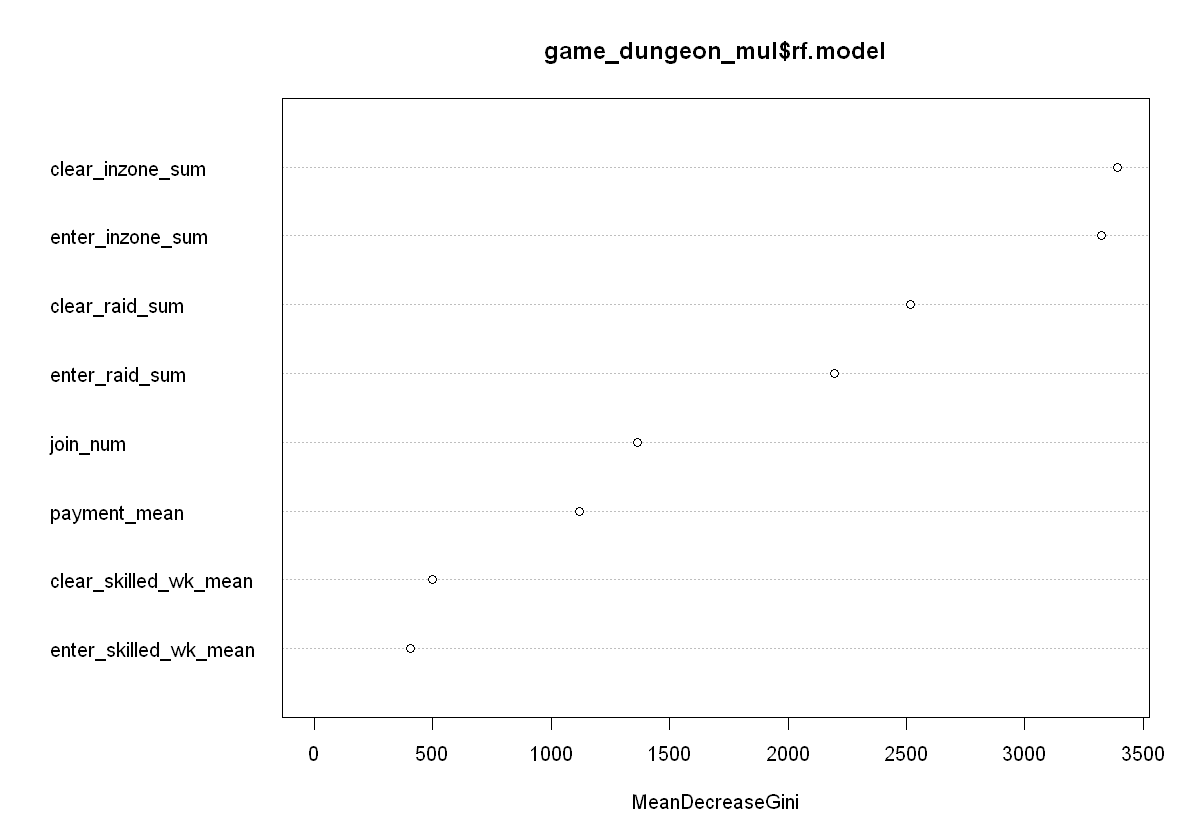

In [69]:
varImp(game_dungeon_mul$rf.model) %>% mutate(Variable = row.names(.)) %>%
  arrange(desc(Overall)) %>% select(Variable, Overall)
varImpPlot(game_dungeon_mul$rf.model)